In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import acorn.core
print(acorn.core.__file__)

import numpy as np
import pandas as pd
import scipy.sparse as sps
import yaml
from itertools import chain, product, combinations
import torch

from time import time as tt
from tqdm import tqdm
import wandb
from acorn.stages.data_reading import AthenaReader
from acorn.core.infer_stage import infer
from acorn.core.eval_stage import evaluate

from acorn.stages.data_reading.models.trackml_utils import *

from acorn.stages.data_reading.data_reading_stage import EventReader
from acorn.stages.data_reading.models.trackml_reader import TrackMLReader

from acorn.stages.graph_construction.models.metric_learning import MetricLearning
from acorn.stages.edge_classifier.models.filter import Filter
from acorn.stages.edge_classifier import InteractionGNN
from acorn.stages.edge_classifier.edge_classifier_stage import EdgeClassifierStage

from acorn.stages.graph_construction.utils import handle_weighting
from acorn.stages.graph_construction.models.utils import graph_intersection, build_edges
from acorn.stages.graph_construction.utils import *
from acorn.stages.graph_construction.models.py_module_map import PyModuleMap
from acorn.stages.graph_construction.graph_construction_stage import GraphConstructionStage

from acorn.stages.track_building import utils 
from torch_geometric.utils import to_scipy_sparse_matrix

#run = wandb.init(project=model_gnn.hparams["project"], entity='gnnproject')

/global/u2/a/alazar/acorn/acorn/core/__init__.py


/global/homes/a/alazar/.conda/envs/acorn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
confidr = "../../examples/CTD_2023/data_reader.yaml"
configmm = "../../examples/CTD_2023/module_map_infer.yaml"
configGnn = "../../examples/CTD_2023/gnn_infer.yaml"
configGnn_eval = "../../examples/CTD_2023/gnn_eval.yaml"
configTbi = "../../examples/CTD_2023/track_building_infer.yaml"
configTbe = "../../examples/CTD_2023/track_building_eval.yaml"

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


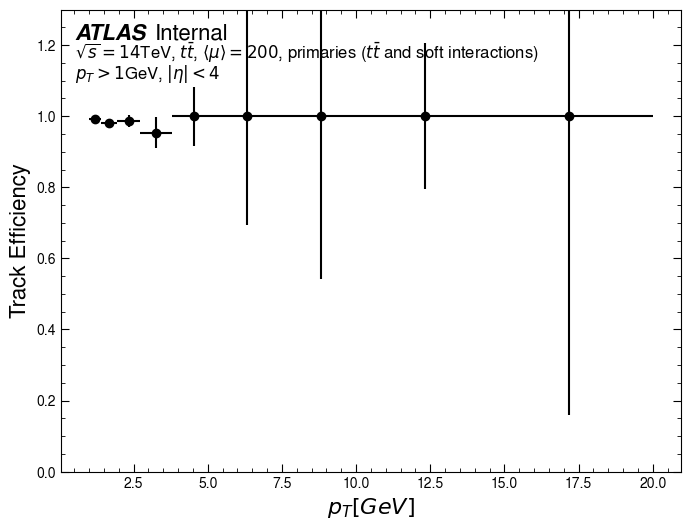

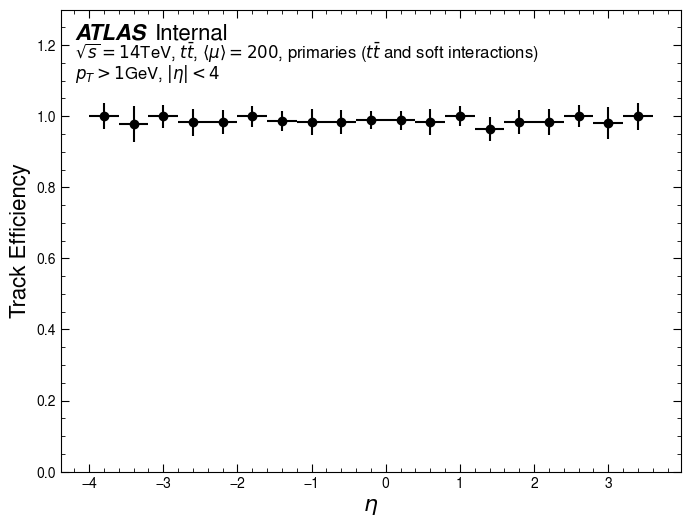

In [6]:
#infer(configmm)
#infer(configGnn)
#evaluate(configGnn_eval,dataset='valset')
#infer(configTbi)
evaluate(configTbe,None)

In [4]:
with open("../../examples/CTD_2023/module_map_infer.yaml", "r") as f:
    config_mm = yaml.load(f, Loader=yaml.FullLoader)
model_mm = PyModuleMap(config_mm)
#model_mm.setup(stage="predict")
model_mm.load_module_map()
model_mm.load_data("/scratch/cf/CTD_2023/feature_store/")

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/cf/CTD_2023/feature_store/trainset'

In [ ]:
with open("../../examples/CTD_2023/gnn_train.yaml", "r") as f:
    config_gnn = yaml.load(f, Loader=yaml.FullLoader)
model_gnn = InteractionGNN(config_gnn)
model_gnn.setup('predict')
model_gnn = InteractionGNN.load_from_checkpoint(config_gnn['stage_dir']+'artifacts/best-v3.ckpt')  
                                                #best-4l0jlwuh-val_loss=0.085163-epoch=77.ckpt')
#dataloaders_gnn = model_gnn.predict_dataloader()

config_tbe = yaml.safe_load(open("../../examples/CTD_2023/track_building_eval.yaml", "r"))
print(config_gnn['stage_dir']+'artifacts')

/global/homes/a/alazar/acorn_new/acorn/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [particle_id] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn_new/acorn/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [nhits] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn_new/acorn/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [primary] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn_new/acorn/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [pdgId] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn_new/acorn/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [ghost] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn_new/acorn/utils/lo

Defining figures of merit
/scratch/cf/Example_1/gnn/artifacts


In [ ]:
def evaluate_labelled_graphs(graphset, config):
    all_y_truth, all_pt  = [], []
    evaluated_events = [
        utils.evaluate_labelled_graph(
            event,
            sel_conf=config["target_tracks"],
            matching_fraction=config["matching_fraction"],
            matching_style=config["matching_style"],
            min_track_length=config["min_track_length"],
        )
        for event in tqdm(graphset)
    ]
    evaluated_events = pd.concat(evaluated_events)

    particles = evaluated_events[evaluated_events["is_reconstructable"]]
    reconstructed_particles = particles[particles["is_reconstructed"] & particles["is_matchable"]]
    tracks = evaluated_events[evaluated_events["is_matchable"]]
    matched_tracks = tracks[tracks["is_matched"]]

    n_particles = len(particles.drop_duplicates(subset=['event_id', 'particle_id']))
    n_reconstructed_particles = len(reconstructed_particles.drop_duplicates(subset=['event_id', 'particle_id']))

    n_tracks = len(tracks.drop_duplicates(subset=['event_id', 'track_id']))
    n_matched_tracks = len(matched_tracks.drop_duplicates(subset=['event_id', 'track_id']))

    n_dup_reconstructed_particles = len(reconstructed_particles) - n_reconstructed_particles

    print(f"Number of reconstructed particles: {n_reconstructed_particles}")
    print(f"Number of particles: {n_particles}")
    print(f"Number of matched tracks: {n_matched_tracks}")
    print(f"Number of tracks: {n_tracks}")
    print(f"Number of duplicate reconstructed particles: {n_dup_reconstructed_particles}")   

    # Plot the results across pT and eta
    eff = n_reconstructed_particles / n_particles
    fake_rate = 1 - (n_matched_tracks / n_tracks)
    dup_rate = n_dup_reconstructed_particles / n_reconstructed_particles

    logging.info(f"Efficiency: {eff:.3f}")
    logging.info(f"Fake rate: {fake_rate:.3f}")
    logging.info(f"Duplication rate: {dup_rate:.3f}")
    print(f"Efficiency: {eff:.3f}")
    print(f"Fake rate: {fake_rate:.3f}")
    print(f"Duplication rate: {dup_rate:.3f}")

In [ ]:
def make_result_summary(
    n_reconstructed_particles,
    n_particles,
    n_matched_tracks,
    n_tracks,
    n_dup_reconstructed_particles,
    eff,
    fake_rate,
    dup_rate,
):
    summary = f"Number of reconstructed particles: {n_reconstructed_particles}\n"
    summary += f"Number of particles: {n_particles}\n"
    summary += f"Number of matched tracks: {n_matched_tracks}\n"
    summary += f"Number of tracks: {n_tracks}\n"
    summary += (
        "Number of duplicate reconstructed particles:"
        f" {n_dup_reconstructed_particles}\n"
    )
    summary += f"Efficiency: {eff:.3f}\n"
    summary += f"Fake rate: {fake_rate:.3f}\n"
    summary += f"Duplication rate: {dup_rate:.3f}\n"

    return summary


def tracking_efficiency(dataset, config): #plot_config,
    """
    Plot the track efficiency vs. pT of the edge.
    """
    all_y_truth, all_pt = [], []
    #dataset = getattr(self, config["dataset"])

    evaluated_events = []
    for event in tqdm(dataset):
        evaluated_events.append(
            utils.evaluate_labelled_graph(
                event,
                matching_fraction=config["matching_fraction"],
                matching_style=config["matching_style"],
                sel_conf=config["target_tracks"],
                min_track_length=config["min_track_length"],
            )
        )

    evaluated_events = pd.concat(evaluated_events)

    particles = evaluated_events[evaluated_events["is_reconstructable"]]
    reconstructed_particles = particles[
        particles["is_reconstructed"] & particles["is_matchable"]
    ]
    tracks = evaluated_events[evaluated_events["is_matchable"]]
    matched_tracks = tracks[tracks["is_matched"]]

    n_particles = len(particles.drop_duplicates(subset=["event_id", "particle_id"]))
    n_reconstructed_particles = len(
        reconstructed_particles.drop_duplicates(subset=["event_id", "particle_id"])
    )

    n_tracks = len(tracks.drop_duplicates(subset=["event_id", "track_id"]))
    n_matched_tracks = len(
        matched_tracks.drop_duplicates(subset=["event_id", "track_id"])
    )

    n_dup_reconstructed_particles = (
        len(reconstructed_particles) - n_reconstructed_particles
    )

    eff = n_reconstructed_particles / n_particles
    fake_rate = 1 - (n_matched_tracks / n_tracks)
    dup_rate = n_dup_reconstructed_particles / n_reconstructed_particles

    result_summary = make_result_summary(
        n_reconstructed_particles,
        n_particles,
        n_matched_tracks,
        n_tracks,
        n_dup_reconstructed_particles,
        eff,
        fake_rate,
        dup_rate,
    )

    print(f"Number of reconstructed particles: {n_reconstructed_particles}")
    print(f"Number of particles: {n_particles}")
    print(f"Number of matched tracks: {n_matched_tracks}")
    print(f"Number of tracks: {n_tracks}")
    print(f"Number of duplicate reconstructed particles: {n_dup_reconstructed_particles}")   
    print(f"Efficiency: {eff:.3f}")
    print(f"Fake rate: {fake_rate:.3f}")
    print(f"Duplication rate: {dup_rate:.3f}")

    #self.log.info("Result Summary :\n\n" + result_summary)

    # res_fname = os.path.join(
    #     self.hparams["stage_dir"],
    #     f"results_summary_{self.hparams['matching_style']}.txt",
    # )

    # with open(res_fname, "w") as f:
    #     f.write(result_summary)

    # First get the list of particles without duplicates
    grouped_reco_particles = particles.groupby("particle_id")[
        "is_reconstructed"
    ].any()
    # particles["is_reconstructed"] = particles["particle_id"].isin(grouped_reco_particles[grouped_reco_particles].index.values)
    particles.loc[
        particles["particle_id"].isin(
            grouped_reco_particles[grouped_reco_particles].index.values
        ),
        "is_reconstructed",
    ] = True
    particles = particles.drop_duplicates(subset=["particle_id"])

    # Plot the results across pT and eta (if provided in conf file)
    #os.makedirs(self.hparams["stage_dir"], exist_ok=True)

    # for var, varconf in plot_config["variables"].items():
    #     utils.plot_eff(
    #         particles,
    #         var,
    #         varconf,
    #         save_path=os.path.join(
    #             self.hparams["stage_dir"],
    #             f"track_reconstruction_eff_vs_{var}_{self.hparams['matching_style']}.png",
    #         ),
    #     )

In [ ]:
device ='cuda'
model_mm = model_mm.to("cuda")
model_gnn = model_gnn.to("cuda")
graphs = []
for batch_idx, (graph, _, truth) in enumerate(model_mm.testset):
    print(batch_idx)
    batch = model_mm.build_graph(graph.to(device), truth).to(device)
    batch.weights = handle_weighting(batch, model_gnn.hparams["weighting"]) #torch.ones_like(batch.y, dtype=torch.float32)
    gnn = model_gnn.shared_evaluation(batch,batch_idx)
    batch = gnn['batch']
    # with torch.no_grad():
    #     if device == 'cuda':
    #         with torch.cuda.amp.autocast():
    #             out = model_gnn(batch)
    # batch.scores = torch.sigmoid(out)
    #model_gnn.log_metrics(gnn['output'],gnn['all_truth'],gnn['target_truth'],gnn['loss'])
    edge_mask = gnn['output'] > 0.8 #model_gnn.hparams['edge_cut'] # score_cut for evaluation
    
    # Get number of nodes
    if hasattr(batch, "num_nodes"):
        num_nodes = batch.num_nodes
    elif hasattr(batch, "x"):
        num_nodes = batch.x.size(0)
    elif hasattr(batch, "x_x"):
        num_nodes = batch.x_x.size(0)
    else:
        num_nodes = batch.edge_index.max().item() + 1
    # Convert to sparse scipy array
    sparse_edges = to_scipy_sparse_matrix(
        batch.edge_index[:, edge_mask], num_nodes=num_nodes
    )
    # Run connected components
    candidate_labels = sps.csgraph.connected_components(
        sparse_edges, directed=False, return_labels=True
    )
    batch.labels = torch.from_numpy(candidate_labels[1]).long()
    graphs.append(batch.to('cpu'))

#evaluate_labelled_graphs(graphs, config_tbe)
tracking_efficiency(graphs, config_tbe)

0
1


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

Number of reconstructed particles: 1263
Number of particles: 2277
Number of matched tracks: 29530
Number of tracks: 41903
Number of duplicate reconstructed particles: 813
Efficiency: 0.555
Fake rate: 0.295
Duplication rate: 0.644
